## Bounding Box model

The concept and data is from this kaggle kernel: [Bounding Box Model](https://www.kaggle.com/martinpiotte/bounding-box-model)

Also from this notebook: [github](https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb)

The idea is standardize the image focus and to make it easier for the classification model to recognize whale id. The data provided was manually created by placing landmarks on the whale tail and using the maximum value of them to create the the cropping location. 

There are 1200 bounding box samples. The data is not from this competition but from the [playground](https://www.kaggle.com/c/whale-categorization-playground) 

Make sure to make to upgrade your fastai. I was using 1.0.38 & 1.0.39 which was giving errors when creating the databunch until it was update to 1.0.41. error: ' can't convert np.ndarray of type numpy.object_.'

In [1]:
import fastai
from fastai import *
from fastai.vision import *
print(f'fastai version: {fastai.__version__}')
print(f'torch version: {torch.__version__}')

verbose = True  # print out extra details?

# import matplotlib.patches.Path
from matplotlib.patches import Rectangle
%matplotlib inline

import json
import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

fastai version: 1.0.41
torch version: 1.0.0


In [2]:
# global setting
data_fp = Path('data')
data_train = data_fp/'train'
data_playground = data_fp/'train_playground'
data_test = data_fp/'train_playground'  # this should be change to train for the cropping
crop_fp = data_fp/'cropping.txt'

In [3]:
bs = 16
num_workers = 3  # set to zero when using kaggle kernel. It crashing the kernel if not
sz = 224 ## resize images

## Look into the cropping dataset

In [ ]:
with open(crop_fp, 'rt') as f:
    crop_ls = [r.split(',') for r in f.read().split('\n') if len(r.split(',')) > 1]

In [ ]:
crop_data = [(img, [(int(coords[i]), int(coords[i+1])) for i in range(0, len(coords), 2)]) 
                                                         for img, *coords in crop_ls]

set([len(r[1]) for r in crop_data])

There are varying number of point pairs for each image ranging from 4 to 11 points. To obtain a bounding box, one need to get the min, max value of the x and y axis. 

Each step converting data into the right format to use
```python
    text file: "image_filename, x1, y1, x2, x3, ... \n .....]
    crop_ls: [image_filename, x1, y1, x2, x3, ...]
    crop_data: [image_filename, [(x1, y1), (x2, y2), ..]]
```

In [ ]:
crop_data[0]

In [ ]:
def get_bbox(coords):
    x, y = [x for x,_ in coords], [y for _,y in coords]
    xmin, xmax= min(x), max(x)
    ymin, ymax = min(y), max(y)
    # lower left corner, width and height
    return xmin, ymin, xmax-xmin, ymax-ymin

def draw_bbox(box):
    return Rectangle((box[0], box[1]), box[2], box[3],
                     linewidth=1, edgecolor='r', facecolor='none')

def img_bbox(data):
    img = PIL.Image.open(data_playground/data[0])
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.axis('off')
    ax.scatter([x for x,_ in data[1]], [y for _,y in data[1]], marker='o', c='r')
    ax.add_patch(draw_bbox(get_bbox(data[1])))
    ax.set_title(data[0])
    plt.show()

In [ ]:
# bbox is created from the landmarks
img_bbox(crop_data[0])

## Convert data into Coco dataset format and then to fastai format


**Coco format**
```json
{
    "categories": [
        {"id": 0, "name": "whale"},
        {"id": 1, "name": "placeholder"}
    ],
    "images": [
        {"id": 1000, "file_name": "whale1.jpg"},
        {"id": 1001, "file_name": "whale2.jpg"}
    ],
    "annotations": [
        {"image_id": 1000, "bbox": [x, y, width, height], "category_id": 0},
        {"image_id": 1001, "bbox": [x, y, width, height], "category_id": 0}
    ]
}
```

**Fastai Format** for multiple objects in an image
```python
[
    [image_fn, image_fn],
    [[
        [[[top, left, bottom, right], 
          [[top, left, bottom, right]], 
         ['whale', 'whale']],
        [[[[top, left, bottom, right], 
          [[top, left, bottom, right]], 
         ['whale', 'whale']]
    ]]  
]
```

In [ ]:
images, annotations = [], []
for i, v in enumerate(crop_data, start=1000):
    images.append({"id": i, "file_name": v[0]})
    annotations.append({"image_id": i, "bbox": get_bbox(v[1]), "category_id": 0})

categories = [{"id": 0, "name": "whale"}]

coco_whale = {"categories": categories,
              "images": images,
              "annotations": annotations}

with open("data/coco_whale.json", "w+") as f:
    json.dump(obj=coco_whale, fp=f, indent=4)

In [ ]:
del images, annotations, categories, coco_whale, i, v, crop_data, crop_fp, crop_ls

## Testing that the conversion was done corrected

In [ ]:
tmp_images, tmp_lbl_bbox = get_annotations('data/coco_whale.json')
len(tmp_images)

coco_dataset format is (x, y, width, height)

fastai expect (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin in the upper left hand corner of the image. 

In [ ]:
img = open_image(Path('data/train_playground')/tmp_images[0])
print(f'BBox coords: {tmp_lbl_bbox[0][0]}')
bbox = ImageBBox.create(*img.size, tmp_lbl_bbox[0][0])
img.show(y=bbox, figsize=(10,10))

In [ ]:
del tmp_images, tmp_lbl_bbox, img, bbox

## Create DataBunch with Coco Format

In [18]:
images, lbl_bbox = get_annotations('data/coco_whale.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o: img2bbox[Path(o).name]

In [19]:
if verbose: lbl_bbox[:2]

In [20]:
tfm = get_transforms(flip_vert=False, 
                     # doesn't make sense to have upside down tails
                     max_rotate=0.3,
                      # rotating too much will cause the bbox to be super large and not accurate
                     max_zoom=1)
                     # remove zooming 
    
if verbose: # show the list of transformation
    for i in tfm:
        for j in i: print(j)
        print("\n")

RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-0.3, 0.3)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)


RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)




In [21]:
# class OneObjectCategoryList(ObjectCategoryList):
#     def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.zeros(1).long().unsqueeze(0)]
# class ObjectItemListOne(ImageItemList):
#     _label_cls,_square_show_res = OneObjectCategoryList,False

# It might just be because windows is not supported that is why i am getting the [Errno 32] Broken pipe
# when ever I do data.show_batch

In [22]:
data = (ObjectItemList.from_df(pd.DataFrame(data=images), path=data_fp, folder='train_playground')
        .random_split_by_pct(seed=52)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .add_test_folder('test')  # TODO change to actual competition data
        .transform(get_transforms(), 
                   tfm_y= True, 
                   size=sz, 
                   resize_method=ResizeMethod.SQUISH,
                   padding_mode='border')
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=num_workers)   
        #Finally we convert to a DataBunch and we use bb_pad_collate
        .normalize(imagenet_stats))

In [23]:
data.test_ds.tfm_y = False  # test set has no y value so no transformation for it

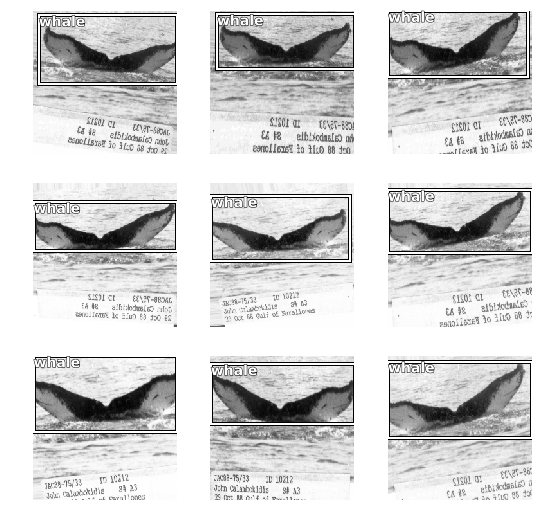

In [24]:
idx = 65
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    img = data.train_ds[idx]
    # image is augmented each time it is retrived
    img[0].show(y=img[1], ax=ax)

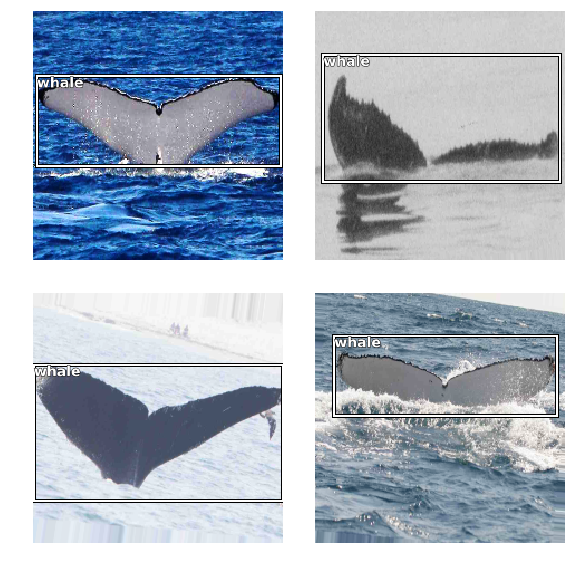

In [25]:
data.show_batch(rows=2)

## Training

First attempt with resnet18 with a simple custom head of nn.Sequential(Flatten(), nn.Linear(25088,4)) did not have good result: the xaxis are out of the range [-1,1] and are consistently around -2.8 and 1.5. the y axis is two narrow. I believe the reason is because the bbox for the xaxis is consistently at the edge of the image and so being outside is reasonable.

Second attempt:
TODO:
* Increase the complexity of the custom head with some non-linear features
* new loss function
* new metrics
* more augmentation
* Use a larger resnet
* increase bs

In [26]:
# L1Loss is used instead of MSE is because MSE penalize mistake more than it should 
def loss_func(preds, targs, class_idx=None, **kwargs):
    return nn.L1Loss()(preds, targs.squeeze())

In [27]:
head_reg4 = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4))
    # Maybe add nn.tanh since the values are [-1,1]
learn = create_cnn(data=data, arch=models.resnet18, pretrained=True, custom_head=head_reg4,
#                    model_dir = '/tmp/models'  ## For kaggle kernel 
                  )
learn.loss_func = loss_func
# change the loss function??

In [14]:
if verbose: print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 112, 112]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 112, 112]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 112, 112]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 56, 56]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 56, 56]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 56, 56]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 56, 56]     0          False     
______________________________________________________________

In [28]:
load_model = (data_fp/'models'/'bounding-box-model.pth').exists()
if load_model:
    learn.load('bounding-box-model');
    print('Trained Model was loaded')

Trained Model was loaded


In [23]:
if not load_model:
    print('testin')

In [24]:
if not load_model:
    learn.lr_find()
    learn.recorder.plot()

In [25]:
if not load_model:
    learn.fit_one_cycle(15, pct_start=0.5)
    learn.recorder.plot_losses()

In [26]:
if not load_model:
    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot()

In [27]:
if not load_model:
    learn.fit_one_cycle(15, max_lr = slice(0.001, 0.001/5), pct_start=0.5)
    learn.save('bounding-box-model', return_path=True)

In [29]:
# check to see if model was loaded corrected by its validation score
learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)[2]

tensor(0.0428)

## Check Validation Set

In [16]:
# implement different loss function like detn_l1
    # IoU??
preds, targs = learn.get_preds(ds_type=DatasetType.Valid)
targs = targs.squeeze()  # fastai outputs multiple objects per image but we only have 1
# making sure the preds values are within the picture
preds = torch.clamp(preds, -1,1)

In [17]:
# check to see what the output looks like
if verbose:
    print(preds.shape, targs.shape)
    print(preds[:2])
    print(targs[:2])

torch.Size([240, 4]) torch.Size([240, 4])
tensor([[-0.5403, -0.9581,  0.2887,  0.9460],
        [-0.7677, -0.9580,  0.6303,  0.9597]])
tensor([[-0.4840, -0.9943,  0.2640,  0.9772],
        [-0.7967, -0.9657,  0.5500,  0.9733]])


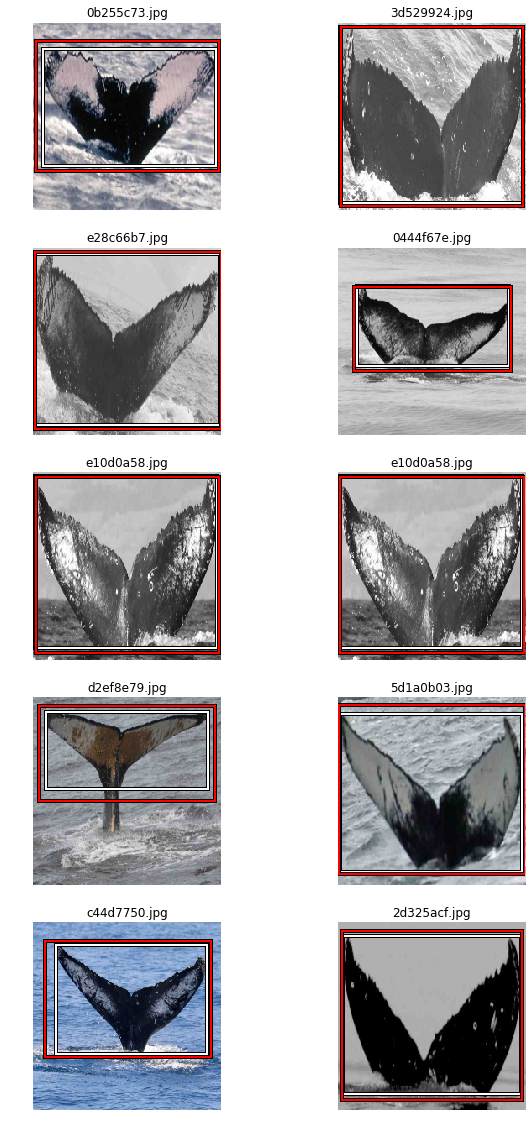

In [19]:
np.random.seed(24)
n = 10  # look at n samples, must be even
idxs = np.random.randint(0,len(data.valid_ds), size=n)
_, axes = plt.subplots(nrows=n//2, ncols=2, figsize = (n, n*2))
for i, ax in zip(idxs, axes.flat):
    img = data.valid_ds[i][0].data  # image resize after data is called else original image size
    img_name = Path(data.valid_ds.items[i]).name
    img_size = img.shape[1:]
    targ, pred = targs[i], preds[i]
    # if verbose: print(f'target: {targ}, pred: {pred}')
    Image(img).show(ax=ax,
                    # target is white
                     y=ImageBBox.create(*img_size, 
                                        bboxes=targ.unsqueeze(0),
                                        scale=False),
                    title=img_name)
    # Prediction is red
    ImageBBox.create(*img_size, 
                     bboxes=pred.unsqueeze(0),
                     scale=False).show(ax=ax, color='red')

## Crop image based on pred (not ready)

### Predict the bounding box

In [30]:
learn.model.eval();

In [31]:
results = []
for img, emptylabel in progress_bar(learn.data.test_ds):
    img = img.data.unsqueeze(dim=0).to('cuda:0')
    # getting image data automatically resize and return a tensor. model expect a batch so batch size of one. 
    with torch.set_grad_enabled(False):
        output = learn.model(img)
    results.append(output.tolist())

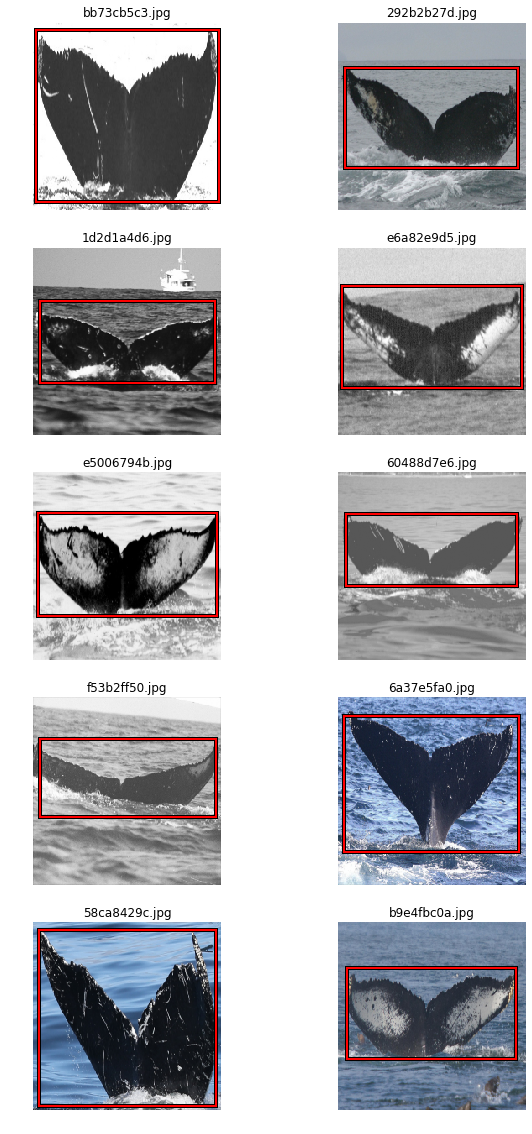

In [32]:
np.random.seed(35)
n = 10  # look at n samples, must be even
idxs = np.random.randint(0,len(data.test_ds), size=n)
_, axes = plt.subplots(nrows=n//2, ncols=2, figsize = (n, n*2))
for i, ax in zip(idxs, axes.flat):
    img = data.test_ds[i][0].data  # image resize after data is called else original image size
    img_name = Path(data.test_ds.items[i]).name
    img_size = img.shape[1:]
    Image(img).show(ax=ax, title=img_name)
    # Prediction is red
    ImageBBox.create(*img_size, 
                     bboxes=results[i],
                     scale=False).show(ax=ax, color='red')

Some of the bounding box are too tight and is cropping the tips of the tail. 

#### Save bounding box to csv

In [35]:
image_bbox = {'filename': [n.name for n in learn.data.test_ds.items],
              'y_upper_left': [x[0][0] for x in results],
              'x_upper_left': [x[0][1] for x in results],
              'y_lower_right': [x[0][2] for x in results],
              'x_lower_right': [x[0][3] for x in results]}
# The bounding box values are normalized to the range of [-1,1] for both y and x axis. So to get the value based on image size, add 1 and multiple by image_size//2. 

In [5]:
bbox_df_fp = data_fp/'bounding_box_coord.csv'

In [36]:
bbox_df = pd.DataFrame.from_dict(image_bbox)
bbox_df.to_csv(bbox_df_fp, index=False)

In [6]:
bbox_df = pd.read_csv(bbox_df_fp)

In [7]:
bbox_df.head()

,filename,y_upper_left,x_upper_left,y_lower_right,x_lower_right
0,00028a005.jpg,-0.621272,-0.847643,0.580249,0.851350
1,000dcf7d8.jpg,-0.941783,-0.983530,0.966192,0.983446
2,000e7c7df.jpg,-0.666750,-0.789982,0.449951,0.777764
3,0019c34f4.jpg,-0.788885,-0.943275,0.841790,0.939747
4,001a4d292.jpg,-0.586286,-0.900535,0.644938,0.899672


### Fix bounding box where the coordinates does not make sense

In [192]:
# fix bounding box that are incorrect format: left/upper should be smaller than right/lower
idx = pd.DataFrame({'y': bbox_df.y_upper_left > bbox_df.y_lower_right, 'x':bbox_df.x_upper_left > bbox_df.x_lower_right}).any(axis=1)
print(f'Number of images: {idx.sum()}')
bbox_df[idx].head(3)

Number of images: 7


,filename,y_upper_left,x_upper_left,y_lower_right,x_lower_right
1196,25d83d815.jpg,3.335762,2.698077,-3.465803,-2.949162
3641,74d2eac26.jpg,33.758896,29.729269,-30.789524,-31.677450
4172,859af97a6.jpg,2.227541,1.736394,-2.468928,-1.916308


In [193]:
idx = idx[idx].index
for i in idx:
    # new bounding box is the whole image
    bbox_df.iloc[i, 1:] = [-1.,-1.,1.,1.]

In [194]:
bbox_df.iloc[idx].head(3) # result

,filename,y_upper_left,x_upper_left,y_lower_right,x_lower_right
1196,25d83d815.jpg,-1.0,-1.0,1.0,1.0
3641,74d2eac26.jpg,-1.0,-1.0,1.0,1.0
4172,859af97a6.jpg,-1.0,-1.0,1.0,1.0


In [195]:
print(f"Unfixed rows: {pd.DataFrame({'y': bbox_df.y_upper_left > bbox_df.y_lower_right, 'x':bbox_df.x_upper_left > bbox_df.x_lower_right}).any(axis=1).sum()}")

Unfixed rows: 0


### Find/Fix bounding box that are outside of the image
Return whole image if prediction isn't accurate

In [196]:
## Any coordinates which is larger than [-1,1]
outofbound = (bbox_df.iloc[:, 1:].abs() > 1).any(axis=1)
print(f'Number of images: {outofbound.sum()}')
bbox_df[outofbound].head(3)

Number of images: 16


,filename,y_upper_left,x_upper_left,y_lower_right,x_lower_right
41,013cb8d04.jpg,-0.864934,-1.010653,0.795518,1.013469
202,05e145d7a.jpg,-0.948363,-0.980186,1.006937,0.980885
722,15dd3f9ef.jpg,-0.884087,-0.993271,0.922186,1.004688


In [197]:
# Clip the range of the value to [-1,1]
bbox_df.iloc[:, 1:] = bbox_df.iloc[:,1:].clip(-1., 1.)

In [198]:
bbox_df[outofbound].head(3) # result

,filename,y_upper_left,x_upper_left,y_lower_right,x_lower_right
41,013cb8d04.jpg,-0.864934,-1.000000,0.795518,1.000000
202,05e145d7a.jpg,-0.948363,-0.980186,1.000000,0.980885
722,15dd3f9ef.jpg,-0.884087,-0.993271,0.922186,1.000000


In [199]:
print(f"Unfixed rows: {(bbox_df.iloc[:, 1:].abs() > 1).any(axis=1).sum()}")

Unfixed rows: 0


### Display some bad bounding boxes

Bounding box values are normal but the box does not capture the whole tail.

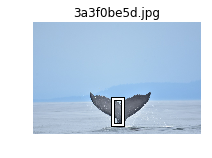

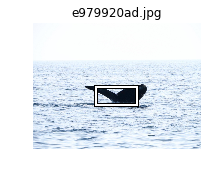

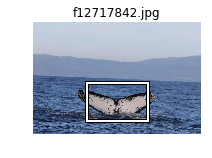

In [200]:
idx = [1808, 7268, 7480]
for i in idx:
    img_fn = bbox_df.filename[i]
    img = open_image(data_fp/'test'/img_fn)
    bbox = get_coord(bbox_df.iloc[i, 1:].as_matrix(), *img.size).tolist()
    img.show(title = img_fn, y=ImageBBox.create(*img.size, bboxes=[bbox], scale=True))

## Crop and save image

In [201]:
test_crop_224_fp = data_fp/'test_crop_224'
test_crop_224_fp.mkdir(exist_ok=True)

In [202]:
def get_coord(bbox:np.ndarray, height:int, width:int):
    # get unnormalized coordinates
    return ((bbox + 1) * ([height//2, width//2]*2)).astype('int')

In [203]:
# Crop image based on bounding box
# Reize image to 224x224
# save image into new folder
for i in progress_bar(range(len(bbox_df))):
    img_fn = bbox_df.filename[i]
    img = open_image(data_fp/'test'/img_fn)
    bbox = get_coord(bbox_df.iloc[i, 1:].as_matrix(), *img.size)
    img = Image(img.data[:, bbox[0]:bbox[2], bbox[1]:bbox[3]])  # crop image
    img = img.apply_tfms([crop_pad()], size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='border')  # resize image
    img.save(test_crop_224_fp/bbox_df.filename[i])

#### Compare original and cropped image

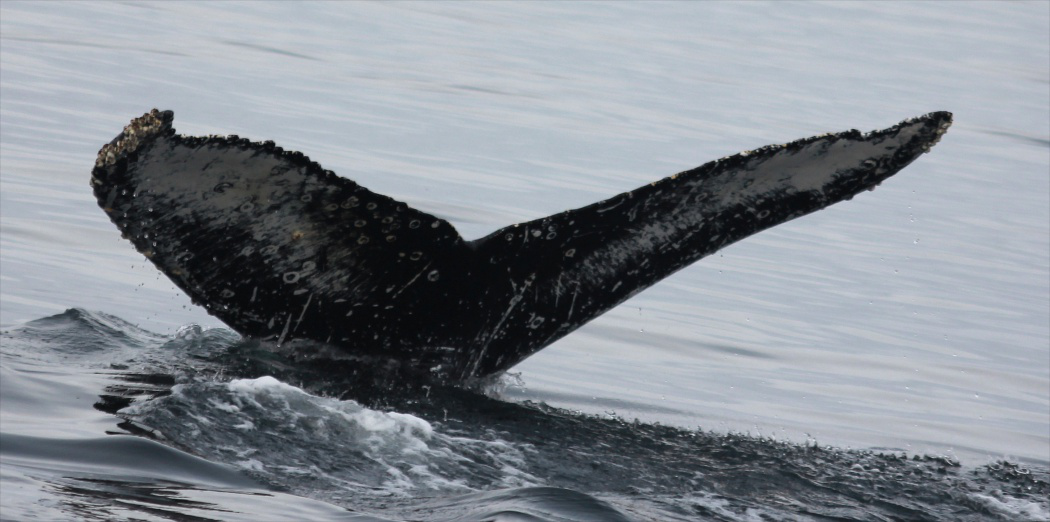

In [204]:
open_image(data_fp/'test'/'00028a005.jpg')

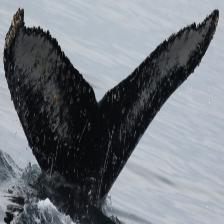

In [205]:
open_image(test_crop_224_fp/'00028a005.jpg')